In [1]:
%pip install spacy
%pip install textblob
%pip install spacytextblob
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora
%pip install ipywidgets


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /home/codespace/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package pun

In [1]:
import os
import glob
import spacy
from textblob import TextBlob
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the English tokenizer, POS tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:

# Define the directory path
dir_path = "aclImdb/test/neg"

# Initialize an empty list to hold the content of each text file
text_data = []

# Loop through each text file in the directory
for filename in glob.glob(os.path.join(dir_path, '*.txt')):
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()
        text_data.append(content)

# Now, text_data is a list where each element is the content of a text file from the directory
print(text_data[0])

I am completely into this type of story line but once the movie fired up, I honestly said out loud, " I just rented a two dollar budget Christian POS". The only thing I could find to like about this film was it has a descent story but it was awfully executed. Horrible actors, horrible direction and producing.<br /><br />The director and producer need to go watch the cube before trying to pull off a movie in a single room. There was absolutely nothing that kept you intrigued to the point that you didn't notice you were in the same room the entire movie. Horrible! The two main actresses were very easy on the eyes and you could tell that was the director counting on to hold your attention. But these two and their bios can speak to this, are horrible in front of the camera.<br /><br />Don't rent this. Unless you are blind, because it might go up a few stars if you only listen to it.


In [4]:


# Initialize an empty list to hold the sentiment scores and temporal markers
sentiment_data = []

# Process every fifth text in the text_data list
for i in tqdm(range(0, len(text_data))):
    text = text_data[i]
    logging.debug(f"Processing text {i}: {text}")
    
    # Process the text using spaCy
    doc = nlp(text)
    
    # Initialize an empty list to hold the sentiment score and temporal marker of each sentence
    sentence_data = []
    
    # Loop through each sentence in the processed text
    for idx, sent in enumerate(doc.sents):
        logging.debug(f"Processing sentence {idx}: {sent}")

        # Perform sentiment analysis using TextBlob
        blob = TextBlob(sent.text)
    
        # Get the sentiment polarity
        sentiment_score = blob.sentiment.polarity
        
        # Assign a temporal marker to the sentence (simply its index in this case)
        temporal_marker = idx
        
        # Append the sentiment score and temporal marker as a tuple to the sentence_data list
        sentence_data.append((sentiment_score, temporal_marker))
    
    # Append the list of sentence data to the sentiment_data list
    sentiment_data.append(sentence_data)

# Now, sentiment_data is a list of lists, where each inner list contains tuples of (sentiment score, temporal marker) for each sentence in every fifth text
print(sentiment_data[0])

  0%|          | 0/9751 [00:00<?, ?it/s]

[(0.19999999999999998, 0), (-0.5, 1), (-0.6904761904761906, 2), (0.06666666666666667, 3), (-1.0, 4), (0.365, 5), (-1.0, 6), (0.0, 7), (0.0, 8), (0.0, 9), (-0.2333333333333333, 10)]


In [4]:

def navier_stokes_sentiment_flow(rho_sent, p_sent, nu_sent, g_context, s):
    """
Calculate the sentiment flow based on the Navier-Stokes equation.

The Navier-Stokes equation is a differential equation that describes the flow of fluid substances like liquids and gases. This function applies the same principles to model the flow of sentiment in a text.

Parameters:
rho_sent (float): The sentiment density, representing the amount of sentiment per unit of text.
p_sent (float): The sentiment pressure, representing the intensity of the sentiment.
nu_sent (float): The sentiment viscosity, representing the resistance to flow of the sentiment.
g_context (float): The external contextual force, representing the influence of the surrounding context on the sentiment.
s (float): The current sentiment state.

Returns:
float: The sentiment flow.
"""
    grad_s = np.gradient(s)
    laplacian_s = np.gradient(grad_s)
    
    if np.any(np.isnan(s)) or np.any(np.isinf(s)) or np.any(np.isnan(grad_s)) or np.any(np.isinf(grad_s)):
        print("Warning: NaN or inf detected in s or grad_s. Skipping this iteration.")
        return None  # Return None to indicate an issue

    convective_term = s * grad_s
    pressure_term = -1 / rho_sent * np.gradient(p_sent)
    viscous_term = nu_sent * laplacian_s
    
    rhs = convective_term + pressure_term + viscous_term + g_context
    
    # Clamping: Prevent values from going to infinity
    np.clip(rhs, -1e10, 1e10, out=rhs)
    
    if np.any(np.isnan(rhs)) or np.any(np.isinf(rhs)):
        print("Warning: NaN or inf detected in rhs. Skipping this iteration.")
        return None  # Return None to indicate an issue
    
    return rhs

In [5]:

# Calculate the density of sentiment (rho_sent) for a given review
def calculate_sentiment_density(sentence_data):
    """
    Calculate the density of sentiment for a given review.

    The sentiment density is defined as the sum of the absolute values of the sentiment scores.

    Parameters:
    sentence_data (list): A list of tuples, where each tuple contains a sentiment score and an index.

    Returns:
    float: The sentiment density of the review.
    """
    
    # Extract just the sentiment scores from the tuples
    sentiment_scores = [score for score, _ in sentence_data]
    return sum(abs(score) for score in sentiment_scores)
# Calculate the pressure of sentiment (p_sent) for a given review
def calculate_sentiment_pressure(sentence_tuple, keywords, text):
    """
    Calculate the sentiment pressure for a given sentence.

    The sentiment pressure is defined as the sentiment score of the sentence if any of the keywords are present in the sentence. Otherwise, it's 0.

    Parameters:
    sentence_tuple (tuple): A tuple containing a sentiment score and an index.
    keywords (list): A list of keywords to check for in the sentence.
    text (spacy.tokens.Doc): A SpaCy Doc object containing the processed text.

    Returns:
    float: The sentiment pressure of the sentence.
    """
    
    score, idx = sentence_tuple
    sentence = list(text.sents)[idx].text
    pressure = 0
    if any(keyword.lower() in sentence.lower() for keyword in keywords):
        pressure += score
    return pressure

# Calculate the viscosity of sentiment (nu_sent) for a given review
def calculate_sentiment_viscosity(sentence_data):
    """
Calculate the sentiment viscosity for a given sentence.

The sentiment viscosity is a measure of the resistance to flow of the sentiment. It can be influenced by various factors such as the complexity of the sentence, the presence of negations, or the use of intensifiers.

Parameters:
sentence (str): The sentence for which to calculate the sentiment viscosity.

Returns:
float: The sentiment viscosity of the sentence.
"""
    # Extract just the sentiment scores from the tuples
    sentiment_scores = [score for score, _ in sentence_data]
    return np.std(sentiment_scores)

# Calculate the external contextual force (g_context) for a given review
def calculate_external_contextual_force(overall_tone):
    """
Calculate the external contextual force for a given sentence.

The external contextual force is a measure of the influence of the surrounding context on the sentiment of the sentence. It can be influenced by various factors such as the sentiment of the surrounding sentences, the overall tone of the text, or the presence of specific contextual cues.

Parameters:
sentence (str): The sentence for which to calculate the external contextual force.

Returns:
float: The external contextual force of the sentence.
"""
    if overall_tone == 'positive':
        return 1
    elif overall_tone == 'negative':
        return -1
    else:
        return 0

In [8]:

def differential_equation(s, t, rho_sent, p_sent, nu_sent, g_context):
    # Use the navier_stokes_sentiment_flow function to compute the derivative
    dsdt = navier_stokes_sentiment_flow(rho_sent, p_sent, nu_sent, g_context, s)
    return dsdt

keywords_example = ['excellent', 'bad']
overall_tone_example = 'negative'
initial_conditions = []

for i in tqdm(range(0, len(text_data))):
    # Taking every fifth text
    text = text_data[i]
    logging.debug(f"Processing text {i}: {text}")
    
    processed_text = nlp(text)
    
    # Taking the corresponding sentiment data
    sentence_data = sentiment_data[int(i)]
    logging.debug(f"Sentence data: {sentence_data}")

    s0 = np.array([score for score, temporal_marker in sentence_data])
    T = len(sentence_data)
    t = np.linspace(0, T-1, T)  # Time array
    
    if len(s0) < 2:
        logging.INFO("Skipping review due to insufficient data for gradient calculation.")
        continue
    
    rho_sent = calculate_sentiment_density(sentence_data)
    if rho_sent == 0:
        logging.INFO("Skipping review due to zero sentiment density.")
        continue
    
    p_sent = np.array([calculate_sentiment_pressure((score, temporal_marker), keywords_example, processed_text) for score, temporal_marker in sentence_data])
    nu_sent = calculate_sentiment_viscosity(sentence_data)
    g_context = calculate_external_contextual_force(overall_tone_example)

    # Use odeint to solve the differential equation
    s = odeint(differential_equation, s0, t, args=(rho_sent, p_sent, nu_sent, g_context))
    
    initial_conditions.append({
        'initial_s': s[0, 0],
        'initial_rho_sent': calculate_sentiment_density(sentence_data[:1]),
        'initial_p_sent': calculate_sentiment_pressure((s[0, 0], 0), keywords_example, processed_text),
        'initial_nu_sent': calculate_sentiment_viscosity(sentence_data[:1]),
        'initial_g_context': calculate_external_contextual_force(overall_tone_example)
    })
    
    # Append also the text of the review to the initial conditions 
    initial_conditions[-1]['text'] = text

print(initial_conditions)
 

  0%|          | 0/1951 [00:00<?, ?it/s]

2023-11-09 10:36:03,204 : DEBUG : Processing text 0: I am completely into this type of story line but once the movie fired up, I honestly said out loud, " I just rented a two dollar budget Christian POS". The only thing I could find to like about this film was it has a descent story but it was awfully executed. Horrible actors, horrible direction and producing.<br /><br />The director and producer need to go watch the cube before trying to pull off a movie in a single room. There was absolutely nothing that kept you intrigued to the point that you didn't notice you were in the same room the entire movie. Horrible! The two main actresses were very easy on the eyes and you could tell that was the director counting on to hold your attention. But these two and their bios can speak to this, are horrible in front of the camera.<br /><br />Don't rent this. Unless you are blind, because it might go up a few stars if you only listen to it.
2023-11-09 10:36:03,205 : DEBUG : len(text): 891
2023-1

KeyboardInterrupt: 

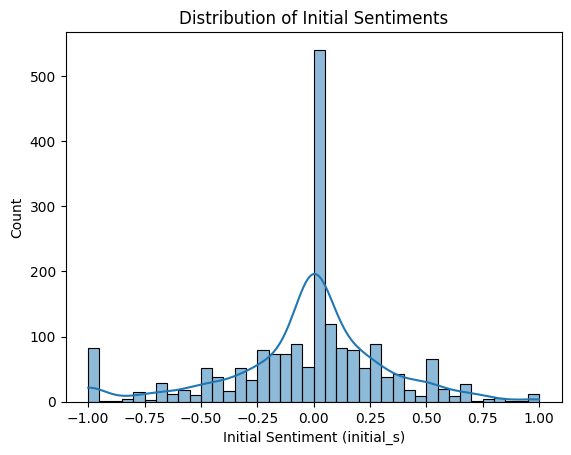

In [7]:


# Supponendo che initial_conditions sia una lista di dizionari
df_initial_conditions = pd.DataFrame(initial_conditions)

# Ora puoi usare sns.histplot con il DataFrame
sns.histplot(df_initial_conditions['initial_s'], kde=True)
plt.title('Distribution of Initial Sentiments')
plt.xlabel('Initial Sentiment (initial_s)')
plt.show()


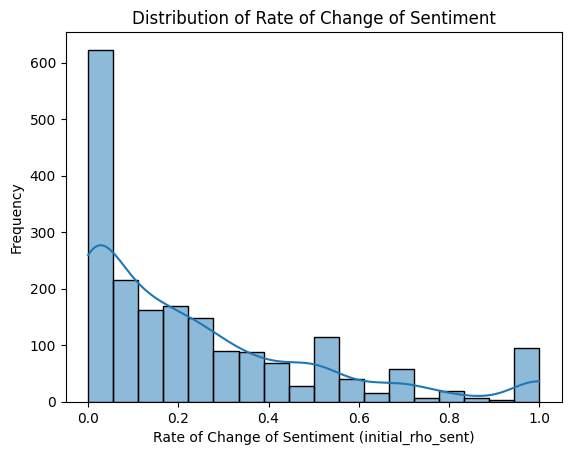

In [8]:

# Analyze the rate of change of sentiment
sns.histplot(df_initial_conditions['initial_rho_sent'], kde=True)
plt.title('Distribution of Rate of Change of Sentiment')
plt.xlabel('Rate of Change of Sentiment (initial_rho_sent)')
plt.ylabel('Frequency')
plt.show()

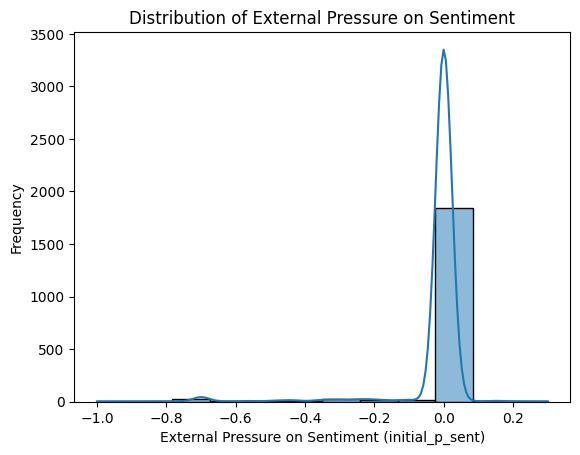

In [9]:

# Analyze the external pressure on sentiment
sns.histplot(df_initial_conditions['initial_p_sent'], kde=True)
plt.title('Distribution of External Pressure on Sentiment')
plt.xlabel('External Pressure on Sentiment (initial_p_sent)')
plt.ylabel('Frequency')
plt.show()

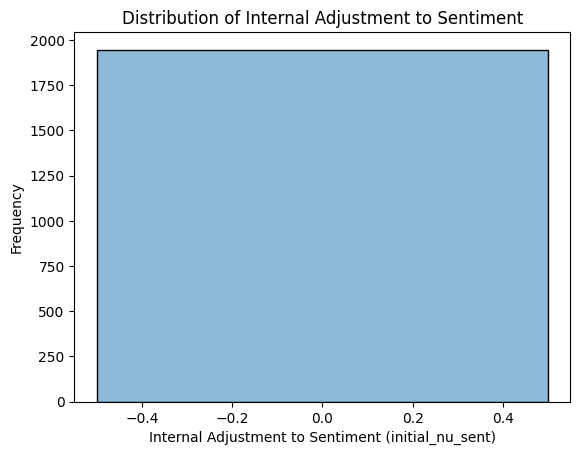

In [10]:

# Analyze the internal adjustment to sentiment
sns.histplot(df_initial_conditions['initial_nu_sent'], kde=True)
plt.title('Distribution of Internal Adjustment to Sentiment')
plt.xlabel('Internal Adjustment to Sentiment (initial_nu_sent)')
plt.ylabel('Frequency')
plt.show()

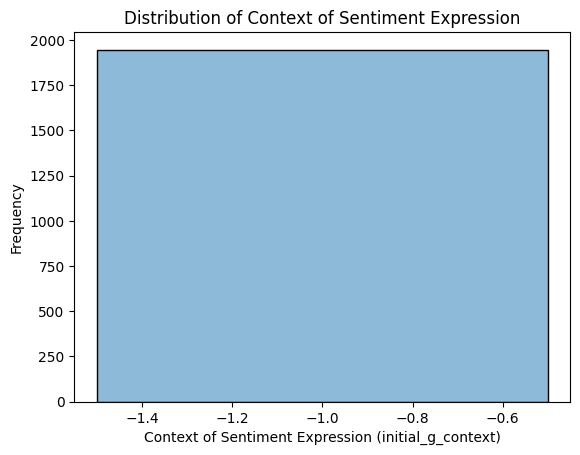

In [11]:

# Analyze the context of sentiment expression
sns.histplot(df_initial_conditions['initial_g_context'], kde=True)
plt.title('Distribution of Context of Sentiment Expression')
plt.xlabel('Context of Sentiment Expression (initial_g_context)')
plt.ylabel('Frequency')
plt.show()

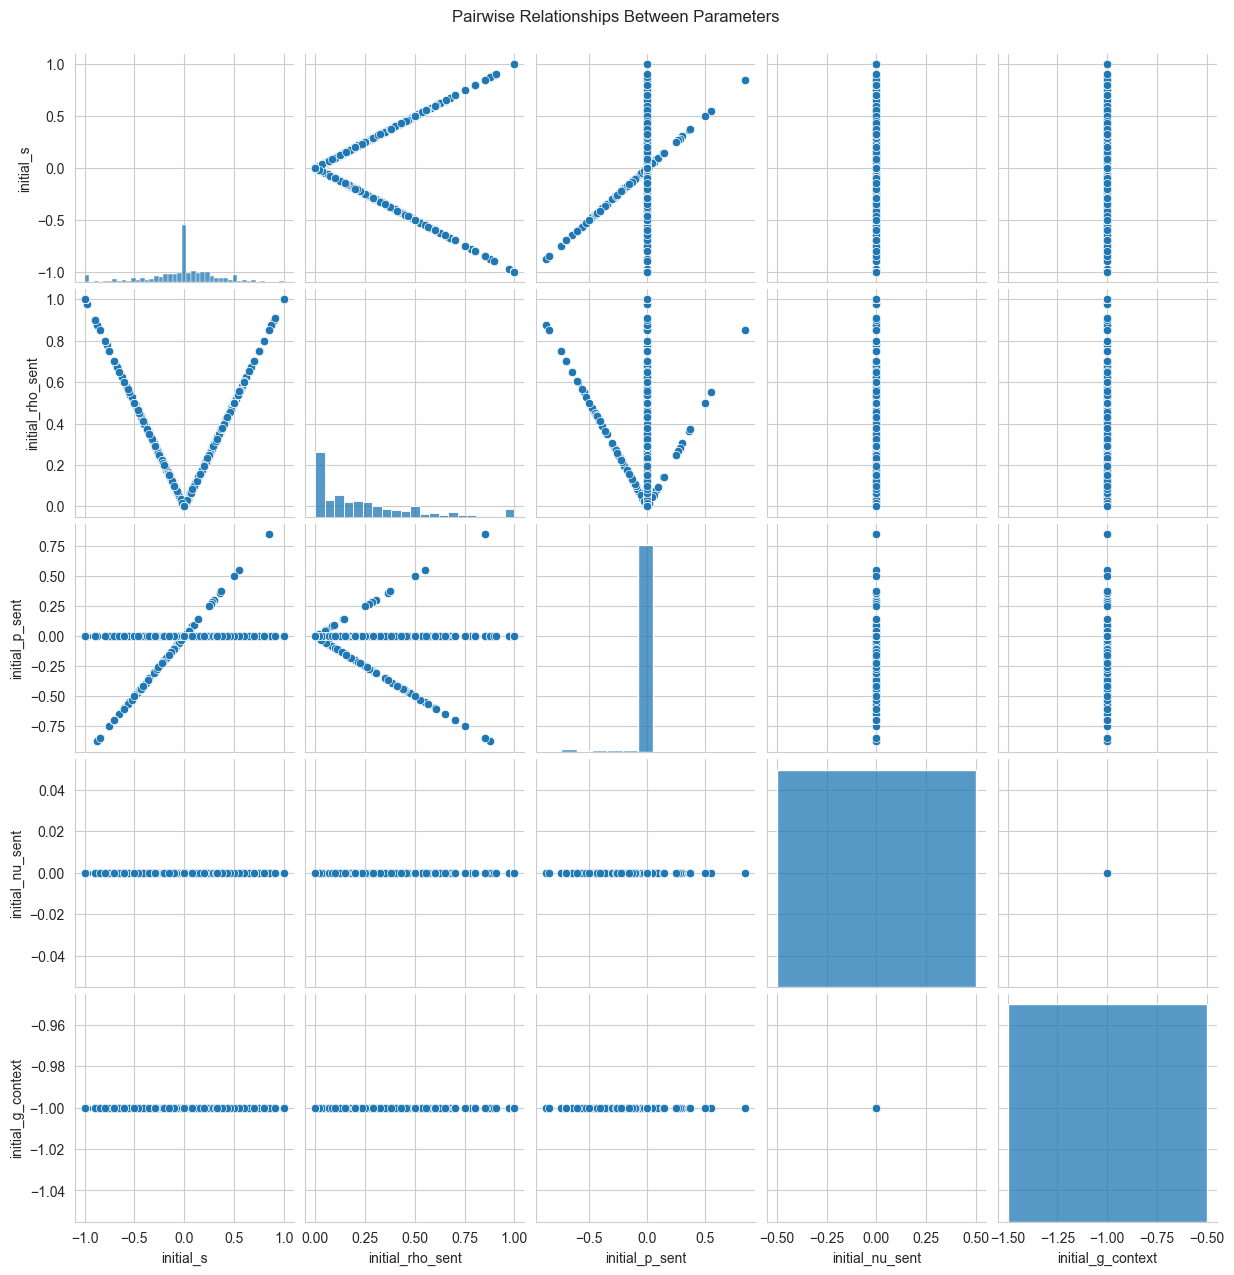

In [20]:

# Pairwise relationships
sns.pairplot(df_initial_conditions)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02)
plt.show()

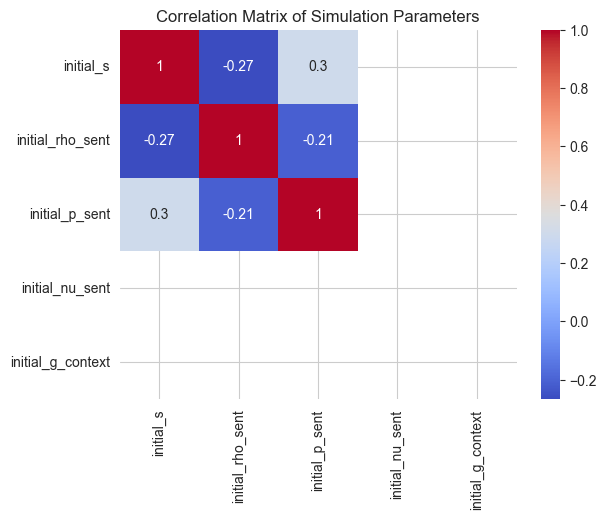

In [21]:

# Correlation matrix heatmap
corr = df_initial_conditions.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Simulation Parameters')
plt.show()

In [23]:

# Look for anomalies or patterns
# Here you can include any specific analysis based on your hypotheses
# For example, to test if initial sentiment and rate of change are correlated:
correlation = df_initial_conditions['initial_s'].corr(df_initial_conditions['initial_rho_sent'])
print(f'Correlation between initial sentiment and rate of change: {correlation}')

# If you have specific hypotheses, you can perform statistical tests here
# For example, a t-test, chi-square test, etc., depending on your hypotheses and data type


Correlation between initial sentiment and rate of change: -0.2673483809921539


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Assuming 's' is the sentiment state variable updated during the simulation
# and each row in 's' corresponds to a different piece of text

# Step 1: Basic Statistics
# Calculate mean, standard deviation, etc.
mean_sentiment = np.mean(s, axis=0)
std_sentiment = np.std(s, axis=0)

print(f"Mean Sentiment: {mean_sentiment}")
print(f"Standard Deviation of Sentiment: {std_sentiment}")

# Step 2: Z-Score Normalization
# This will help us identify outliers or exceptionally strong sentiments
z_scores = zscore(s, axis=0)

Mean Sentiment: [-1.33248324e+05 -1.00520810e+05 -4.92606517e+04 -2.52720206e+02
 -2.66522932e+00 -2.72719240e+00 -2.78700366e+00 -2.92481826e+00
 -3.05497723e+00 -3.14773634e+00]
Standard Deviation of Sentiment: [3.99738638e+05 3.01556071e+05 1.47775414e+05 7.51202222e+02
 9.68145439e-01 1.16705429e+00 1.40931510e+00 1.42946538e+00
 1.51999200e+00 1.63715949e+00]


In [ ]:

# Step 4: Heatmap for Sentiment Evolution
# This will show us how the sentiment evolves for all pieces of text
s_reshaped = s.reshape(-1, 1)  # Reshape to 2D array with one column

plt.figure(figsize=(10, 6))
sns.heatmap(s_reshaped, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Sentiment Flow Over Time')
plt.xlabel('Time Step')
plt.ylabel('Text Index')
plt.show()

In [89]:

# Step 5: Clustering (Optional)
# You can use clustering algorithms like K-means to group similar sentiment flows together
from sklearn.cluster import KMeans
# Assuming 's' is your 1D array
s_reshaped = s.reshape(-1, 1)  # Reshape the array to 2D

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(s_reshaped)

# Add the cluster labels back to your DataFrame (if you're using one)
# df['Cluster'] = clusters

# Now you can analyze each cluster separately to understand its characteristics


/Users/dpicca/Library/Caches/pypoetry/virtualenvs/computionaltextdynamics-y-hZwXiu-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.